Problem: Predict days after crypto price (in USD) ups and downs probaility

Excepted output: Best dataset and model combination to use and the combination detail which help to select

Used algorithm: KNN (knn), GaussianNB (nb), RandomForest (rfc)

Input: 
1. datasets : 1 to 3 years BTC-USD and ETH-USD dataset
    - put in the same folder with naming: 
            "1_year_BTC_USD.csv", "2_years_BTC_USD.csv", "3_years_BTC_USD.csv",
            "1_year_ETH_USD.csv", "2_years_ETH_USD.csv", "3_years_ETH_USD.csv"
2. day_to_predict : days to predict (e.g., 7 days after, it ups or downs?)
3. min_accepted_rate : between 0 and 1. 
    - it defines the minimal number of accepted cases rate
    - it affects the probability suggested to determine the prediction is really going to ups. (Which is the confidence)

Dataset source:

    https://finance.yahoo.com/quote/ETH-USD/history/
    https://finance.yahoo.com/quote/BTC-USD/history/

Period: 1 to 3 years

Dataset column:

    Date, Open, High, Low, Close, Adj Close, Volume
    
Label:
    
    0 : downs
    1 : ups

In [ ]:
# import dependiences
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from timeit import default_timer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from multiprocessing import cpu_count,  Pool
cpu_number = cpu_count()
program_start_time = default_timer()

In [ ]:
# read dataset one by one to prevent leap year
datasets = {
            # bitcoin
            "1_year_BTC_USD" : {}, "2_years_BTC_USD" : {}, "3_years_BTC_USD" : {},
            # eth
            "1_year_ETH_USD" : {}, "2_years_ETH_USD" : {}, "3_years_ETH_USD" : {}
}

# datasets = {"1_year_BTC_USD":{}}

day_to_predict = 1
min_accepted_rate = 0.5

In [ ]:
# read dataset for training and evaluation
for key in datasets.keys():
    # read dataset by key name
    dataset = np.genfromtxt(f"{key}.csv", delimiter=",")
    # remove date and column name
    dataset = dataset[1:, 1:]
    # assign dataset
    datasets[key]["dataset"] = dataset
    datasets[key]["models"] = {}

In [ ]:
# data preprocessing
def calculate_up_down(data):
    # data = [open, high, low, close, adj_close, volume]
    up_down = data[3]-data[0]
    if up_down > 0:
        return [up_down, 1]
    else: # including no change
        return [up_down, 0]

# add change, label(up/down=1/0) to each dataset
for key in datasets.keys():
    results = []
    dataset = datasets[key]["dataset"]
    for data in dataset:
        results.append(calculate_up_down(data))
    
    # change to np array
    results = np.array(results)
    
    # spilt change and label
    # remove last row because it will be removed in dataset
    changes = results[:-day_to_predict,0]
    changes = changes.reshape((changes.shape[0],1))
    # remove first days to predict label so when concatenate, it become the next day up/down
    labels = results[day_to_predict:,1]
    labels = labels.reshape((labels.shape[0],1))
    # remove last days to predict row in dataset because it will not have next day up/down
    dataset = dataset[:-day_to_predict]
        
    # dataset become [open, high, low, close, adj_close, volume, change, label]
    datasets[key]["dataset"] = np.concatenate((dataset, changes, labels), axis=-1)

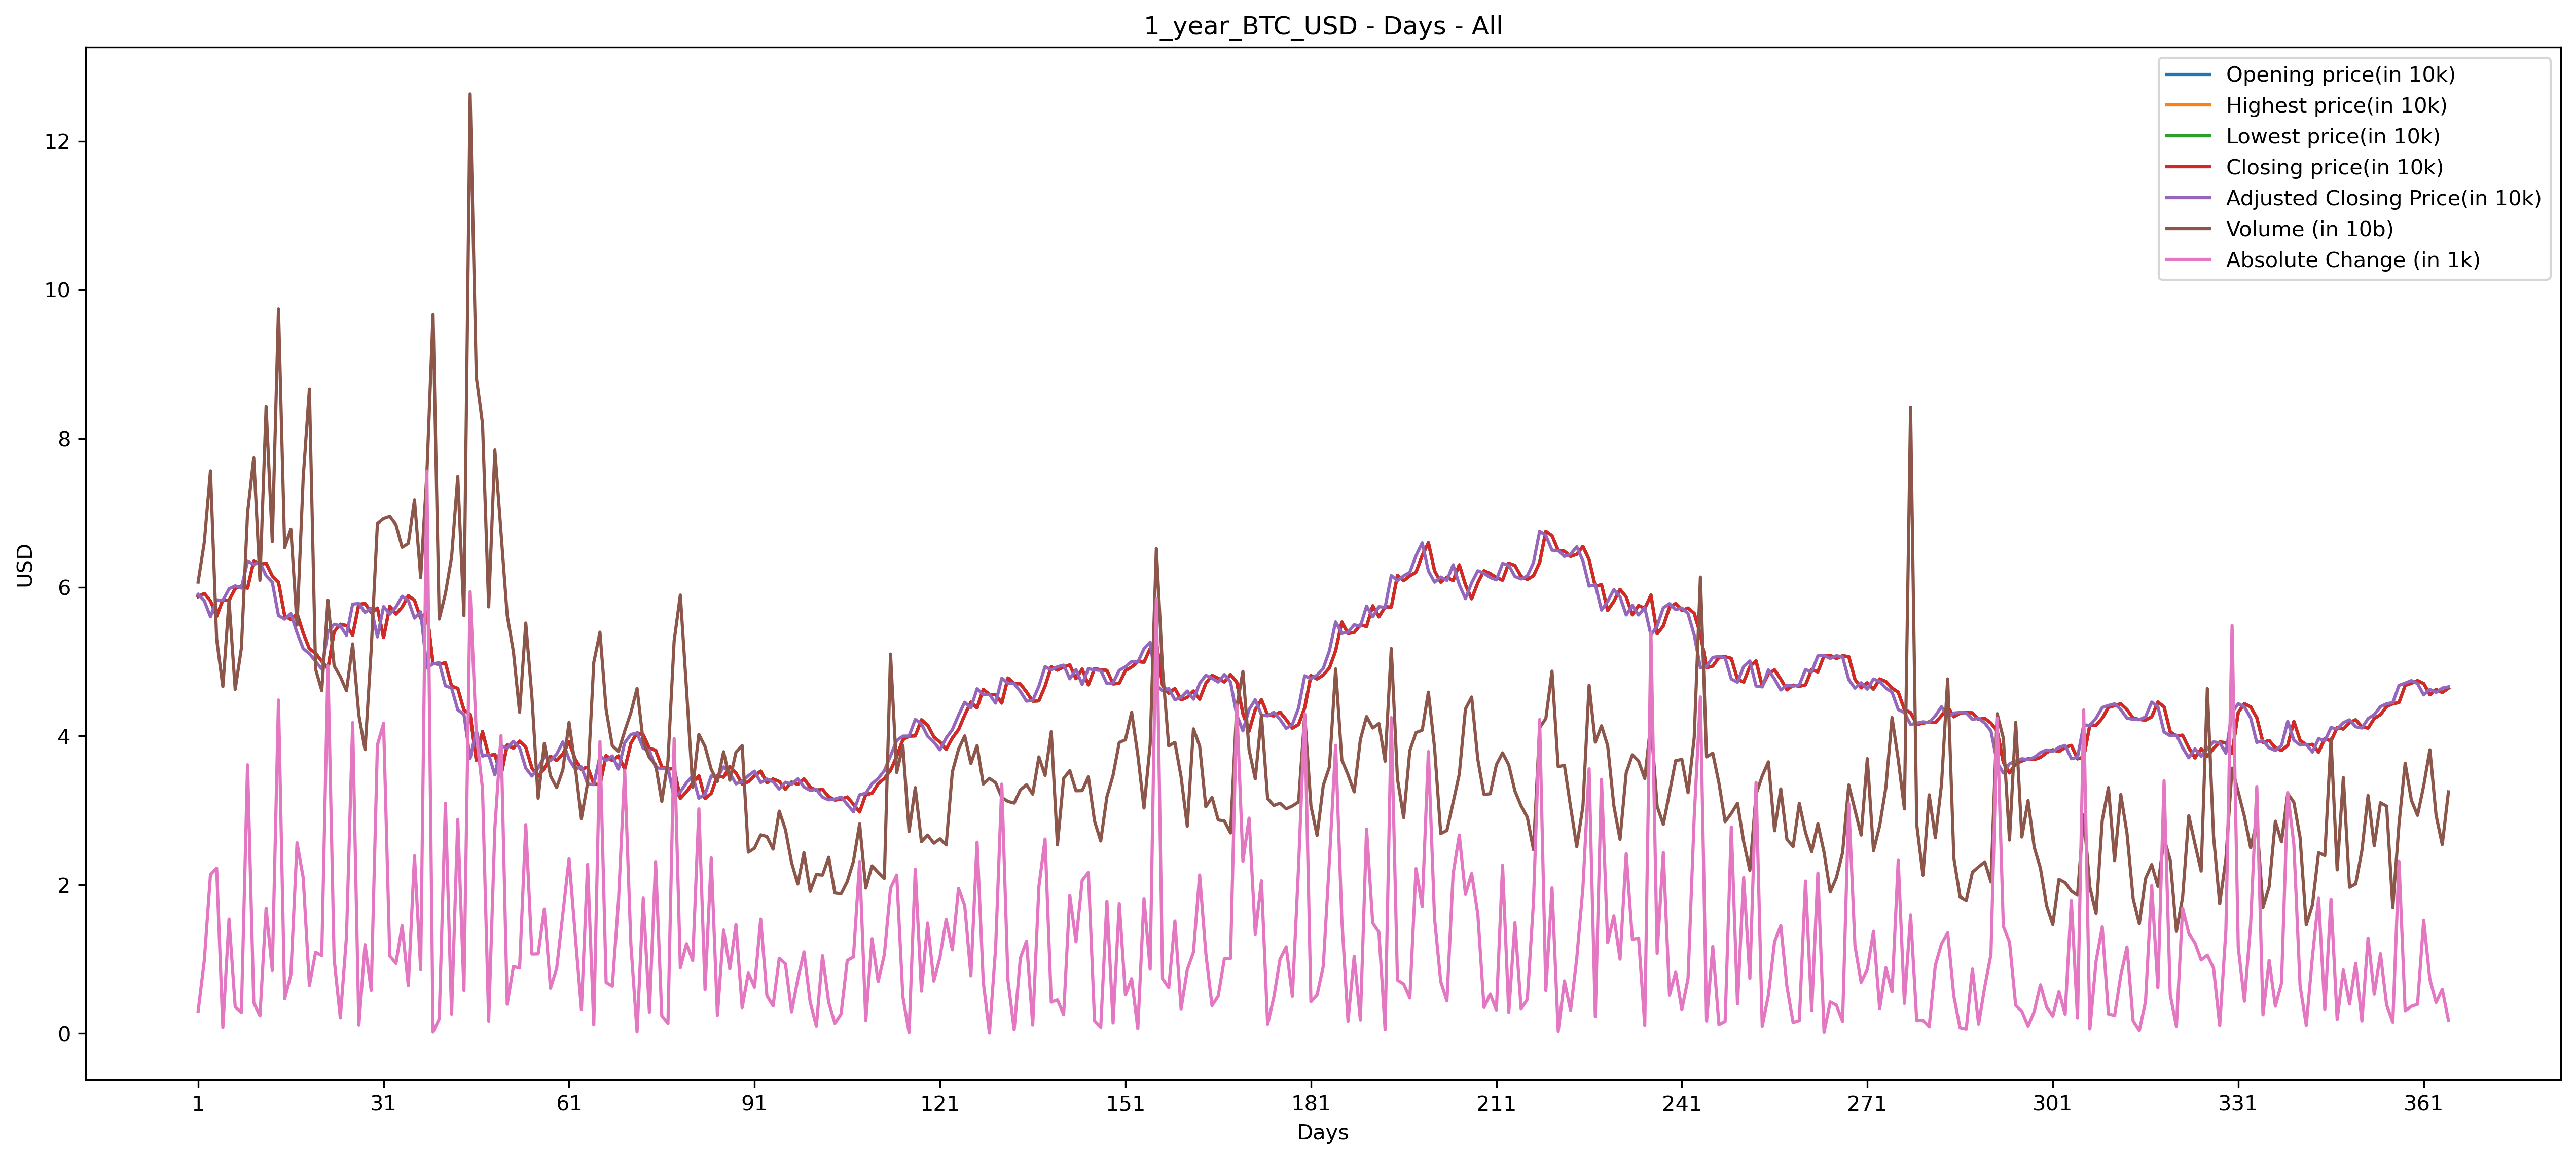

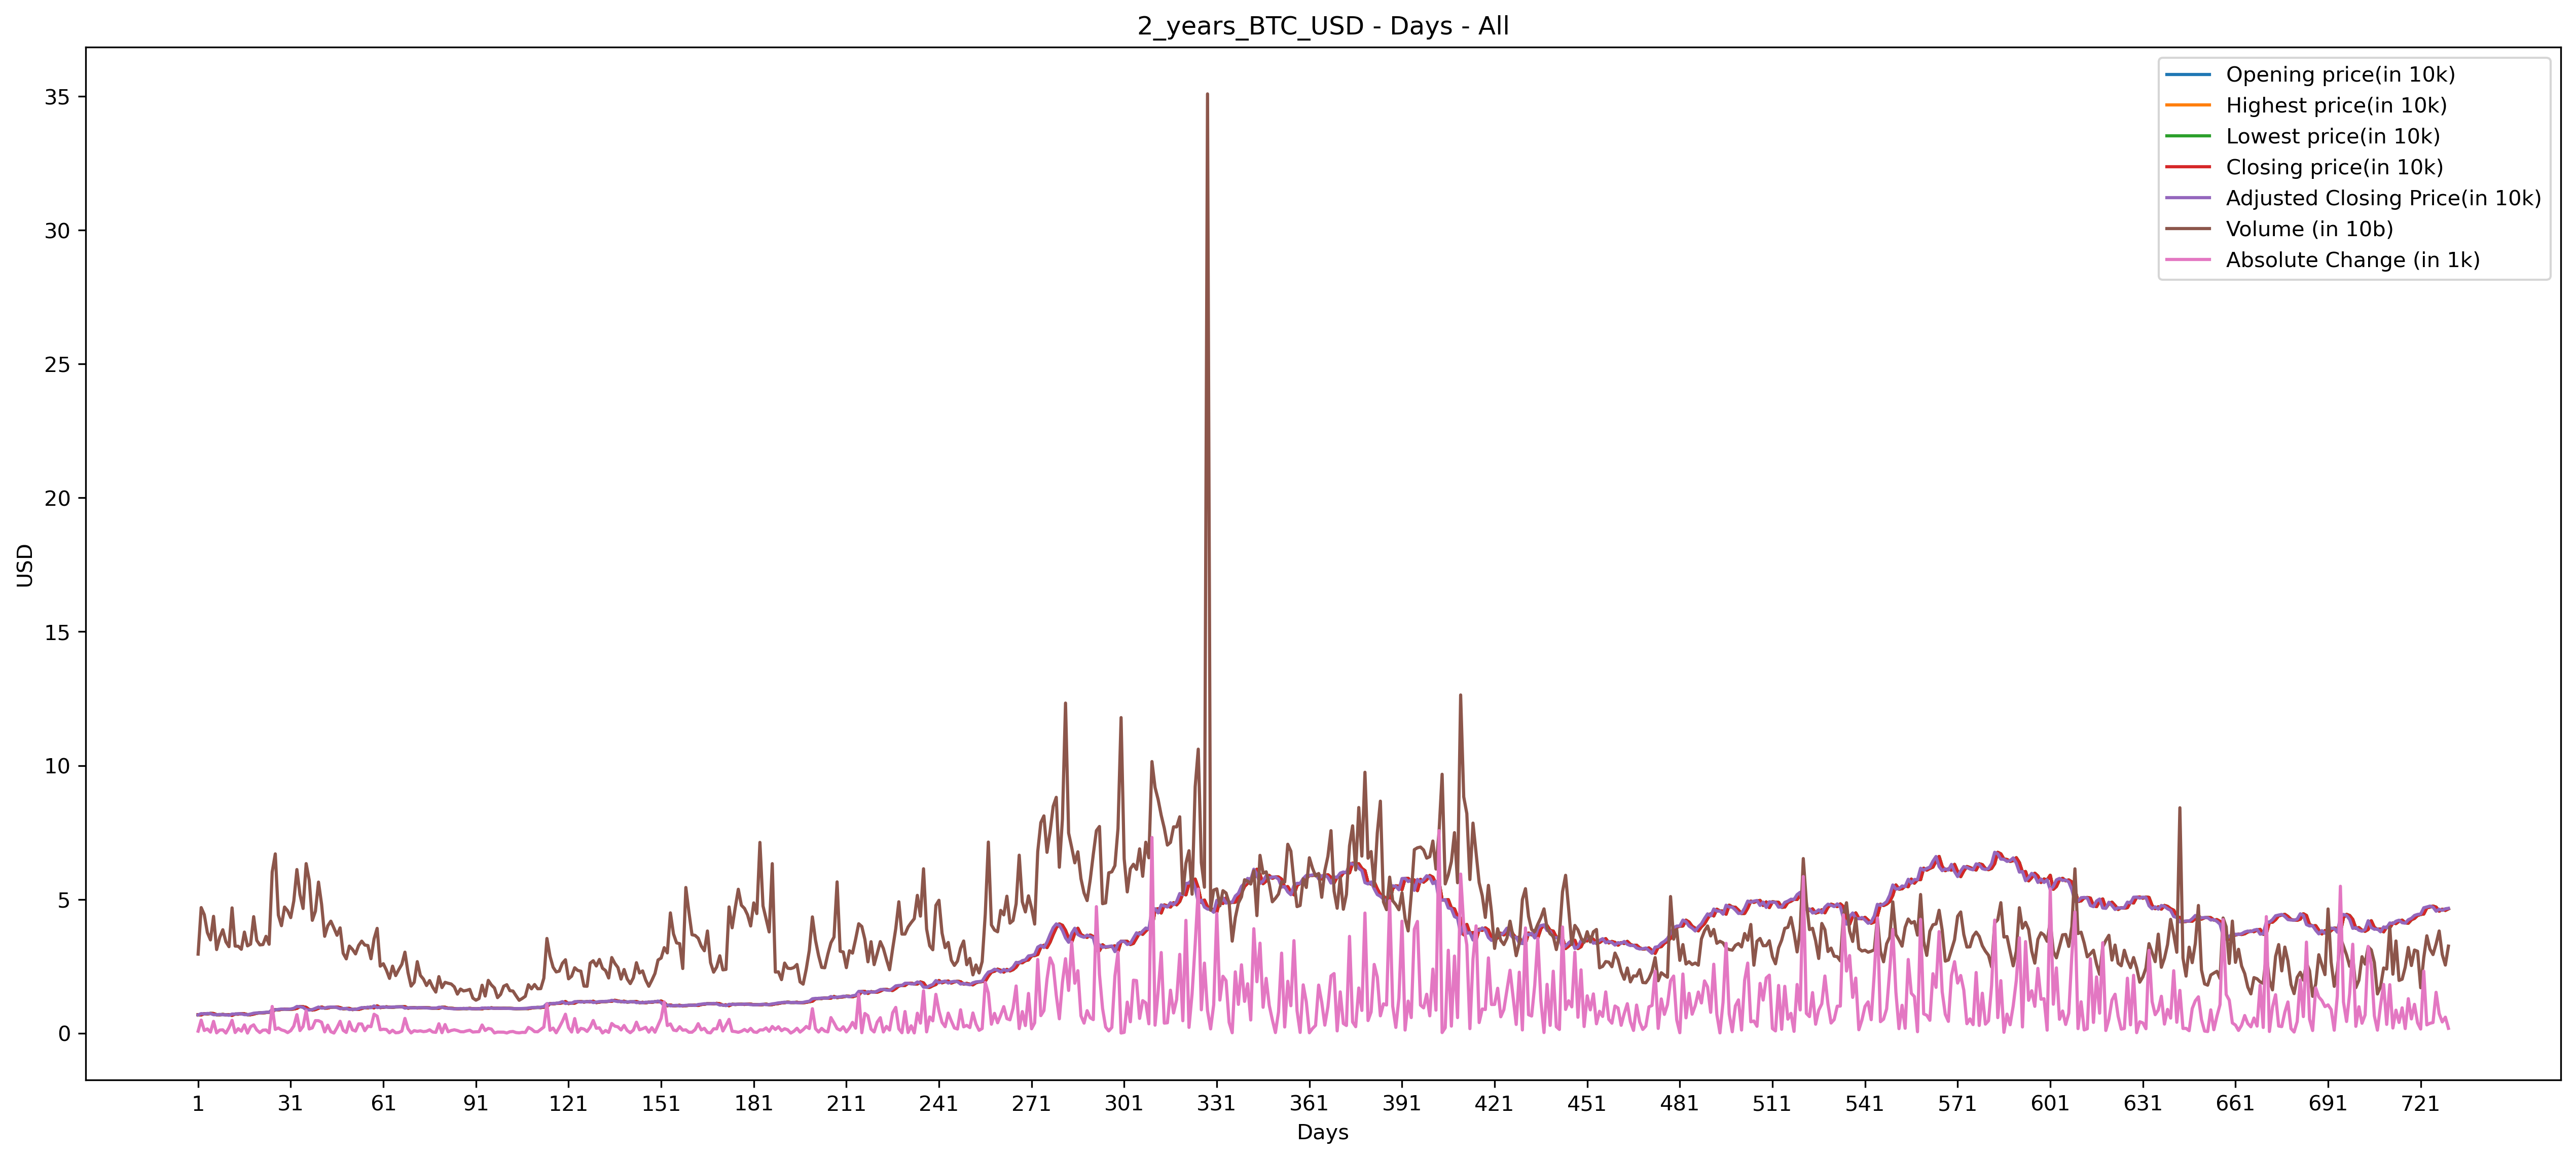

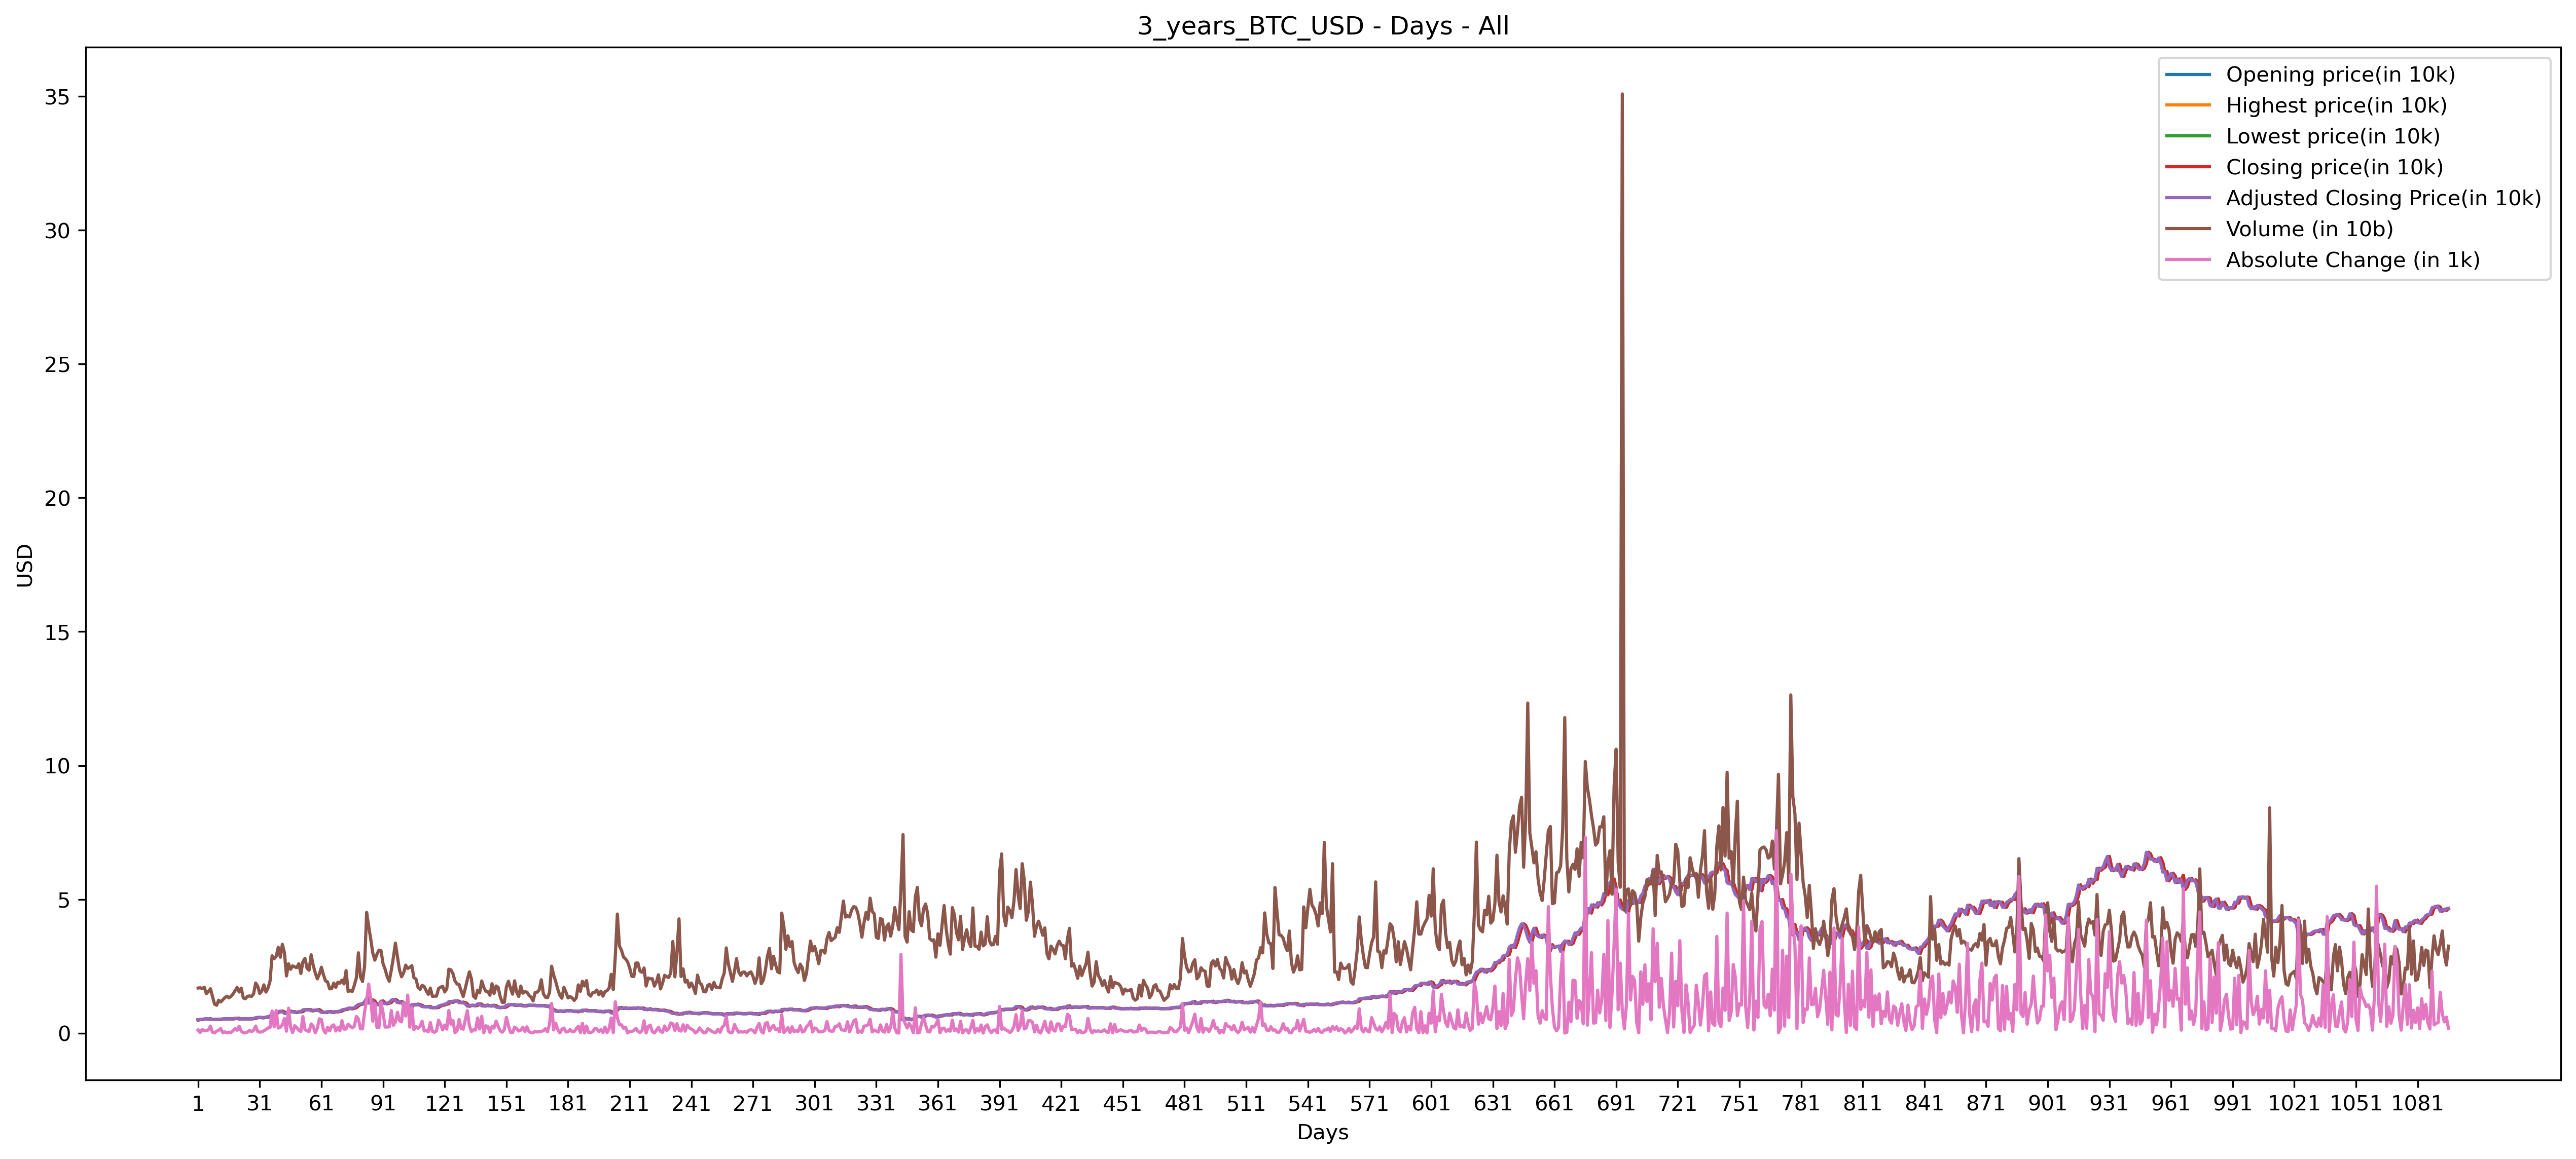

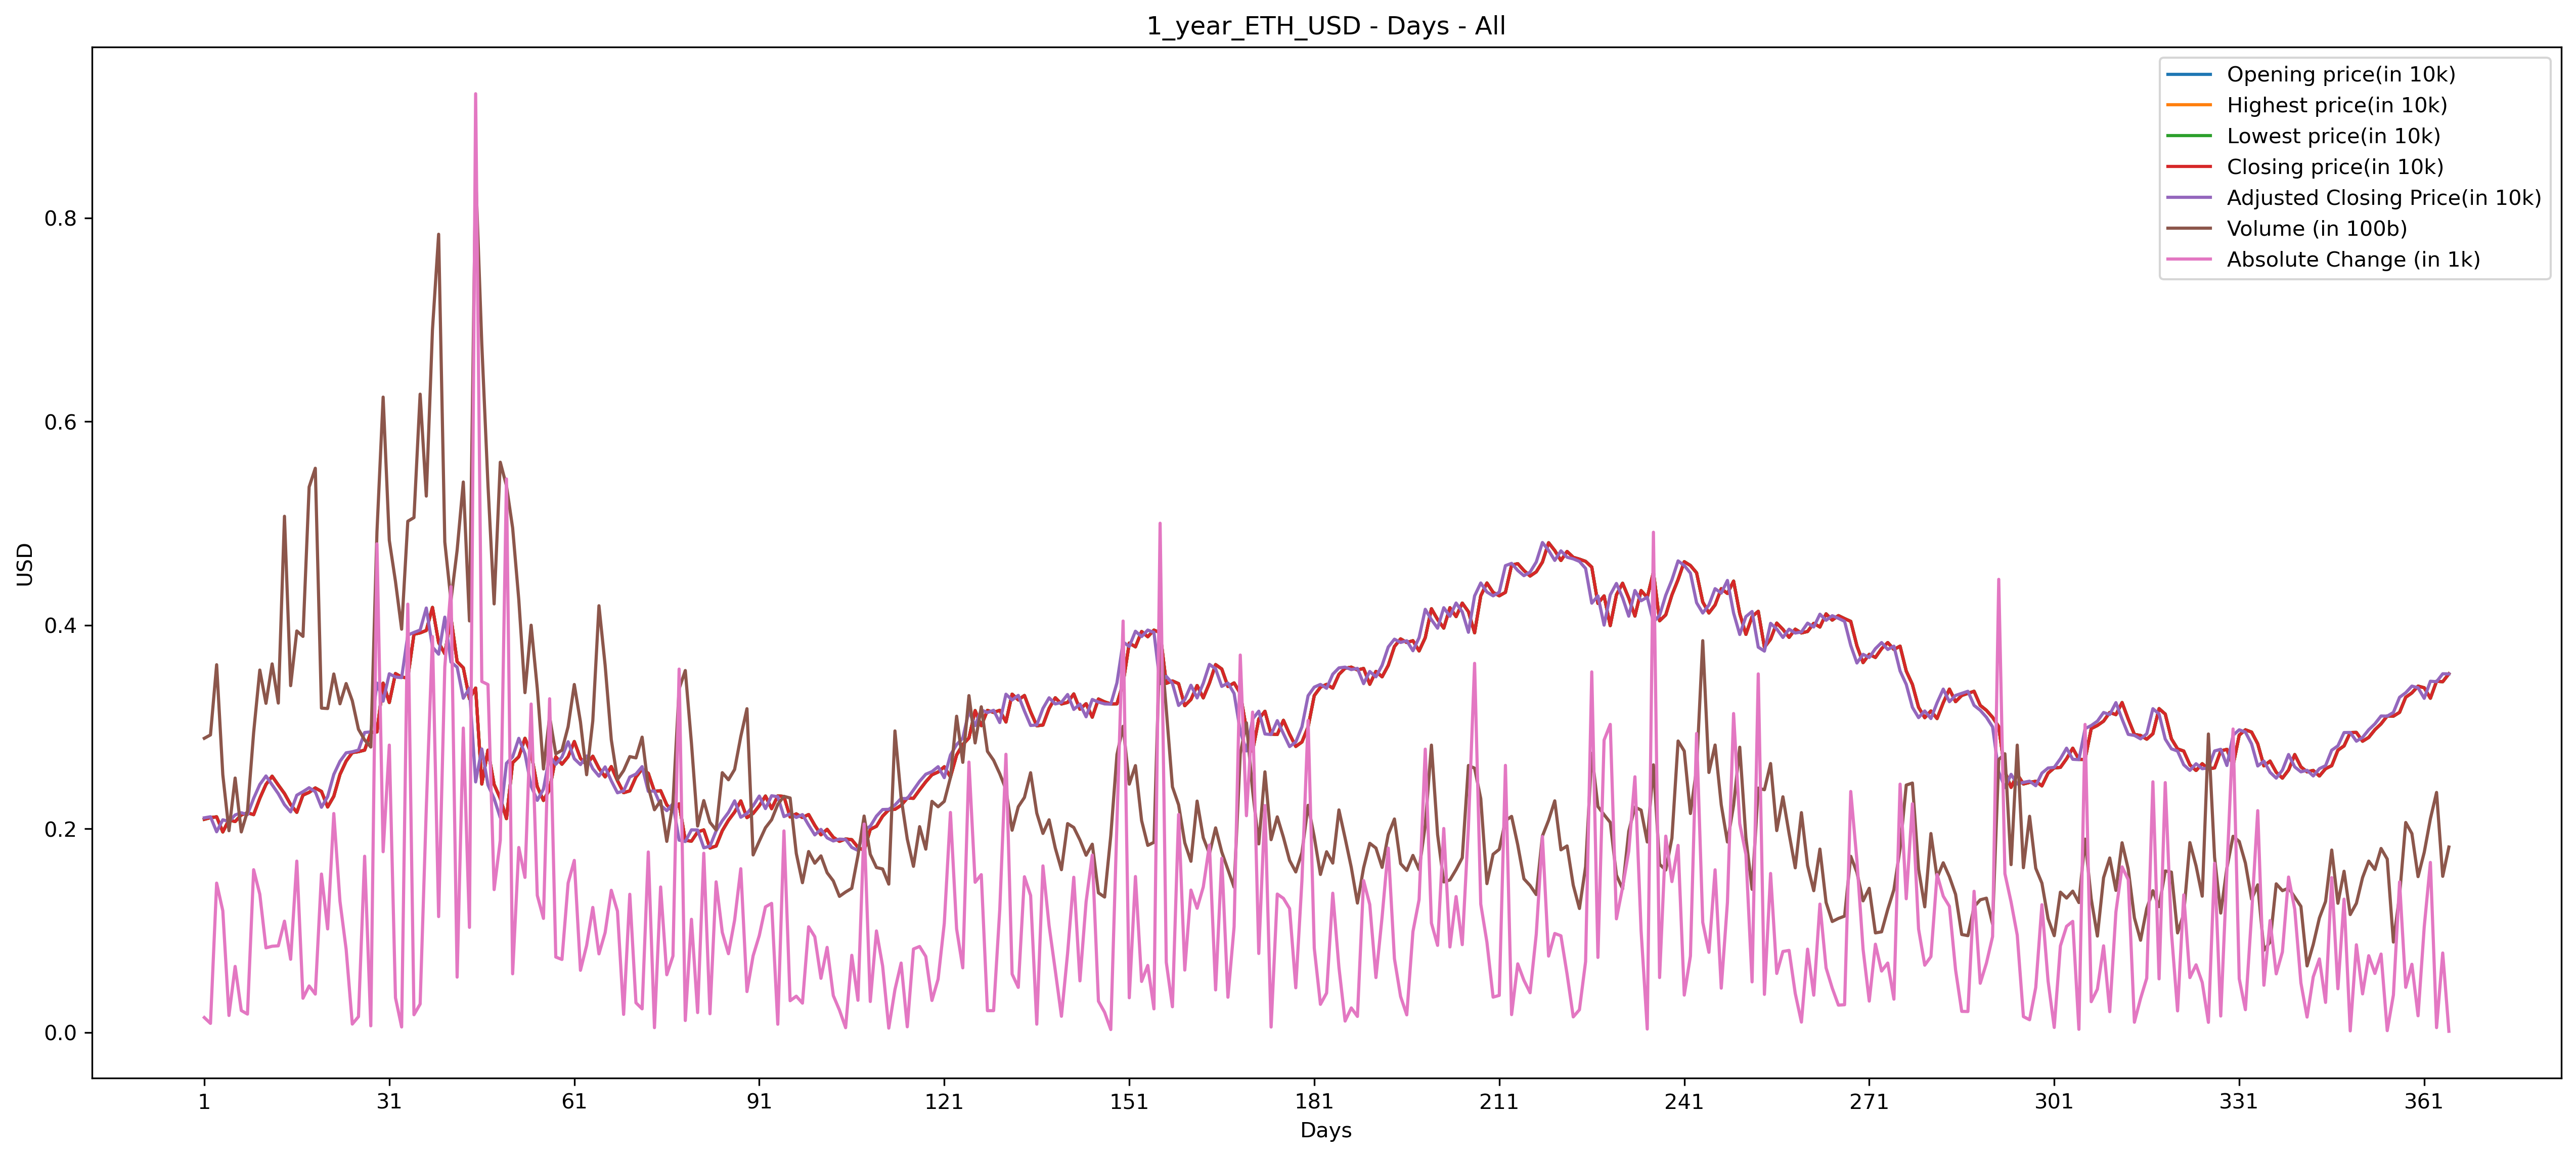

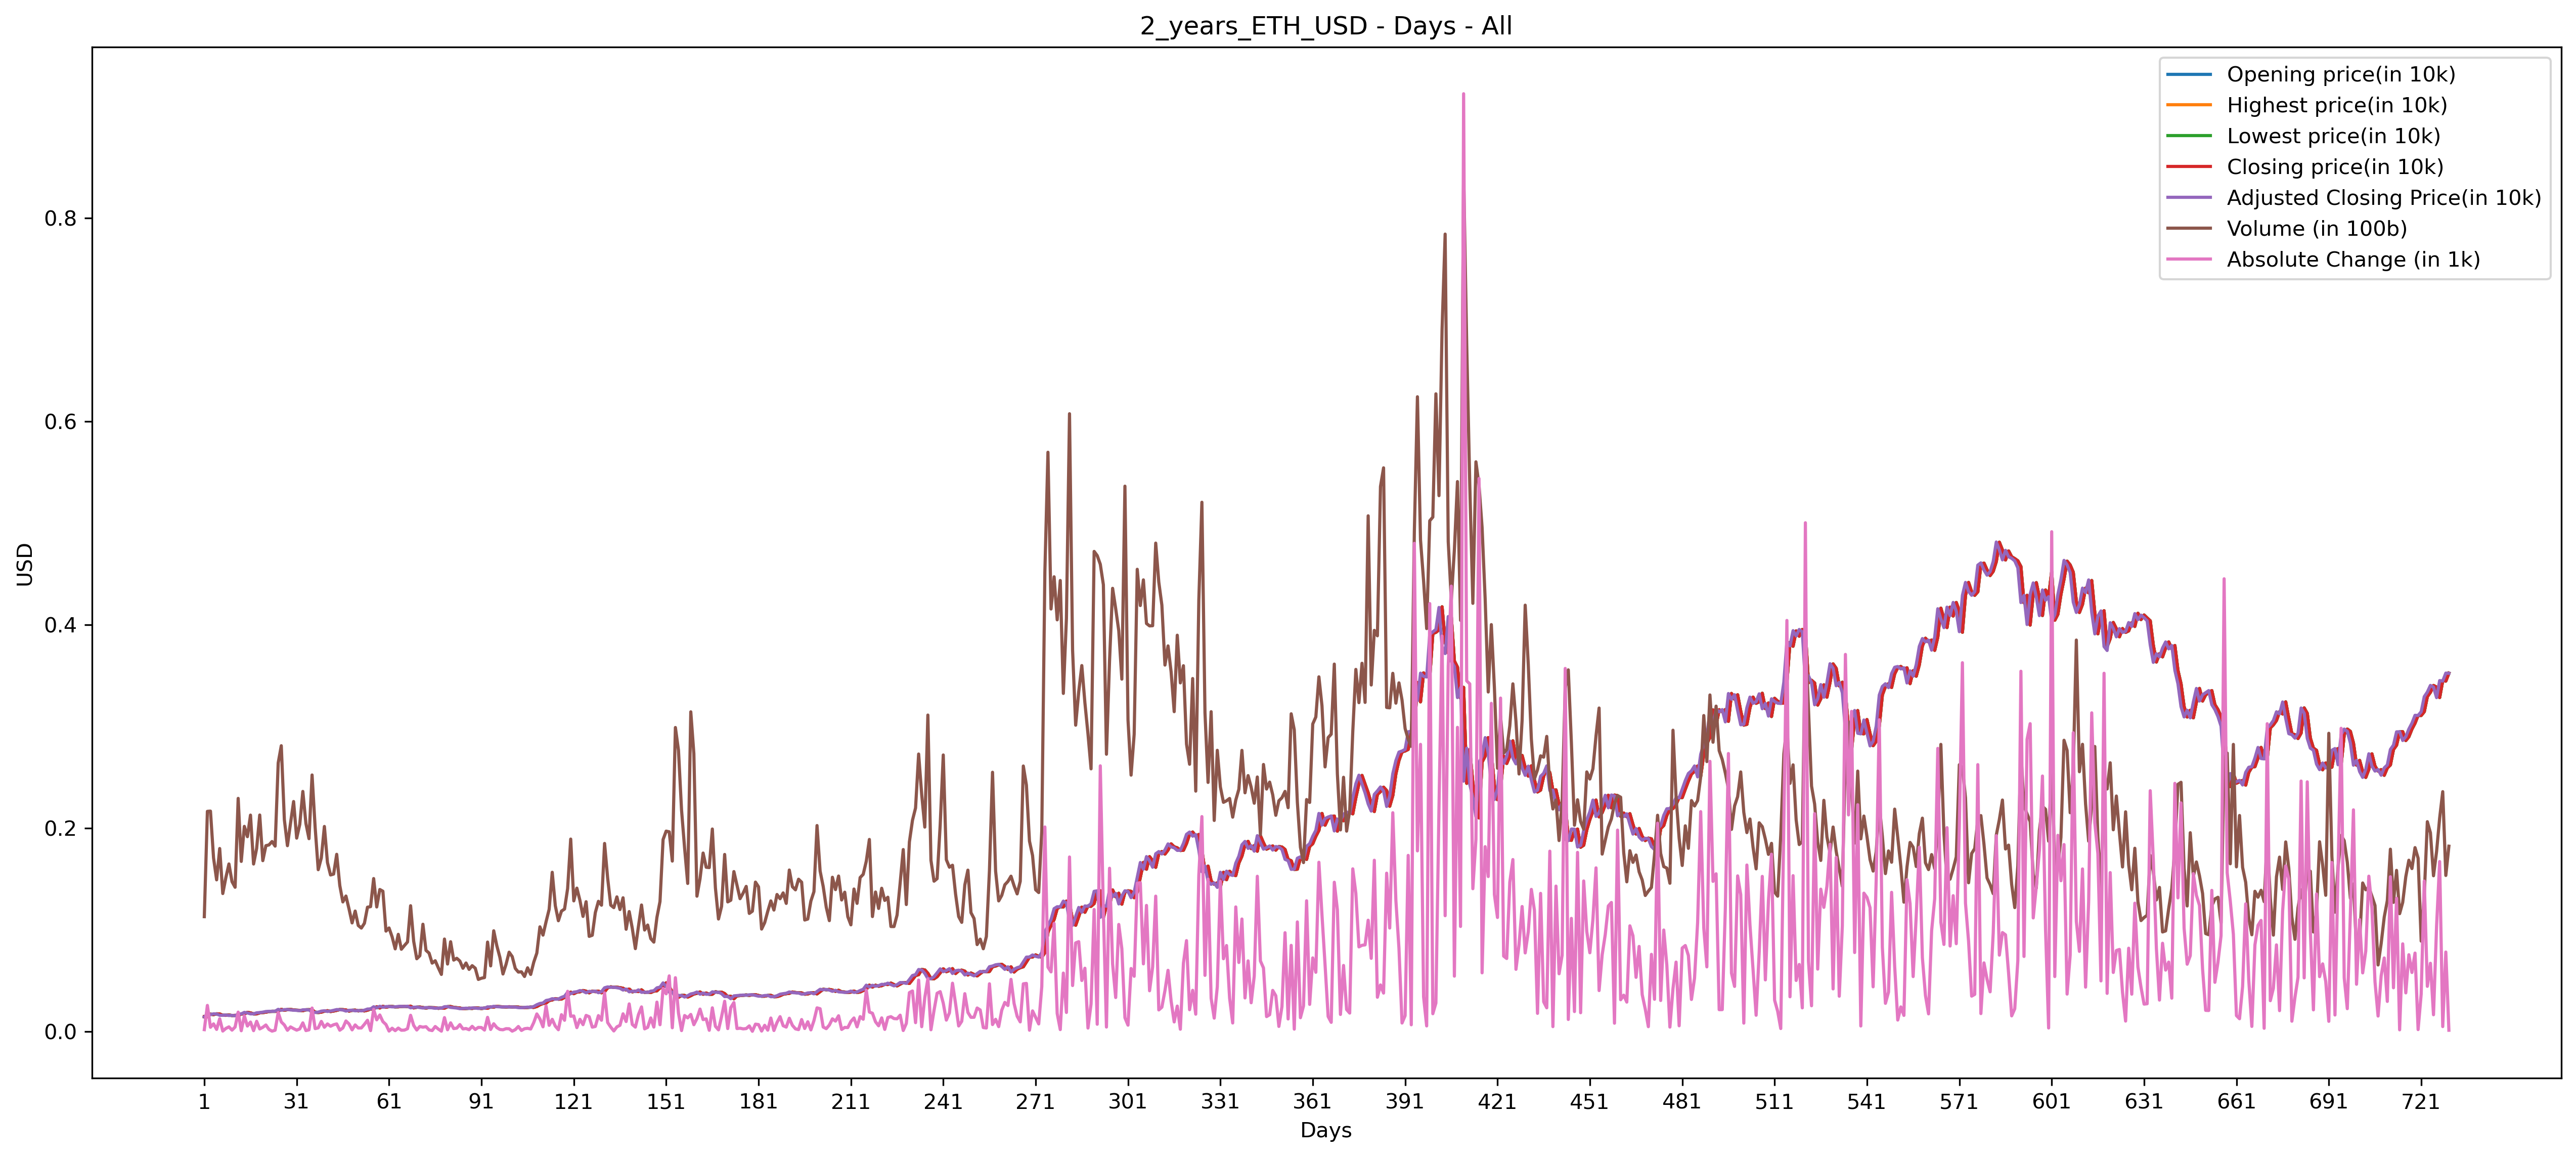

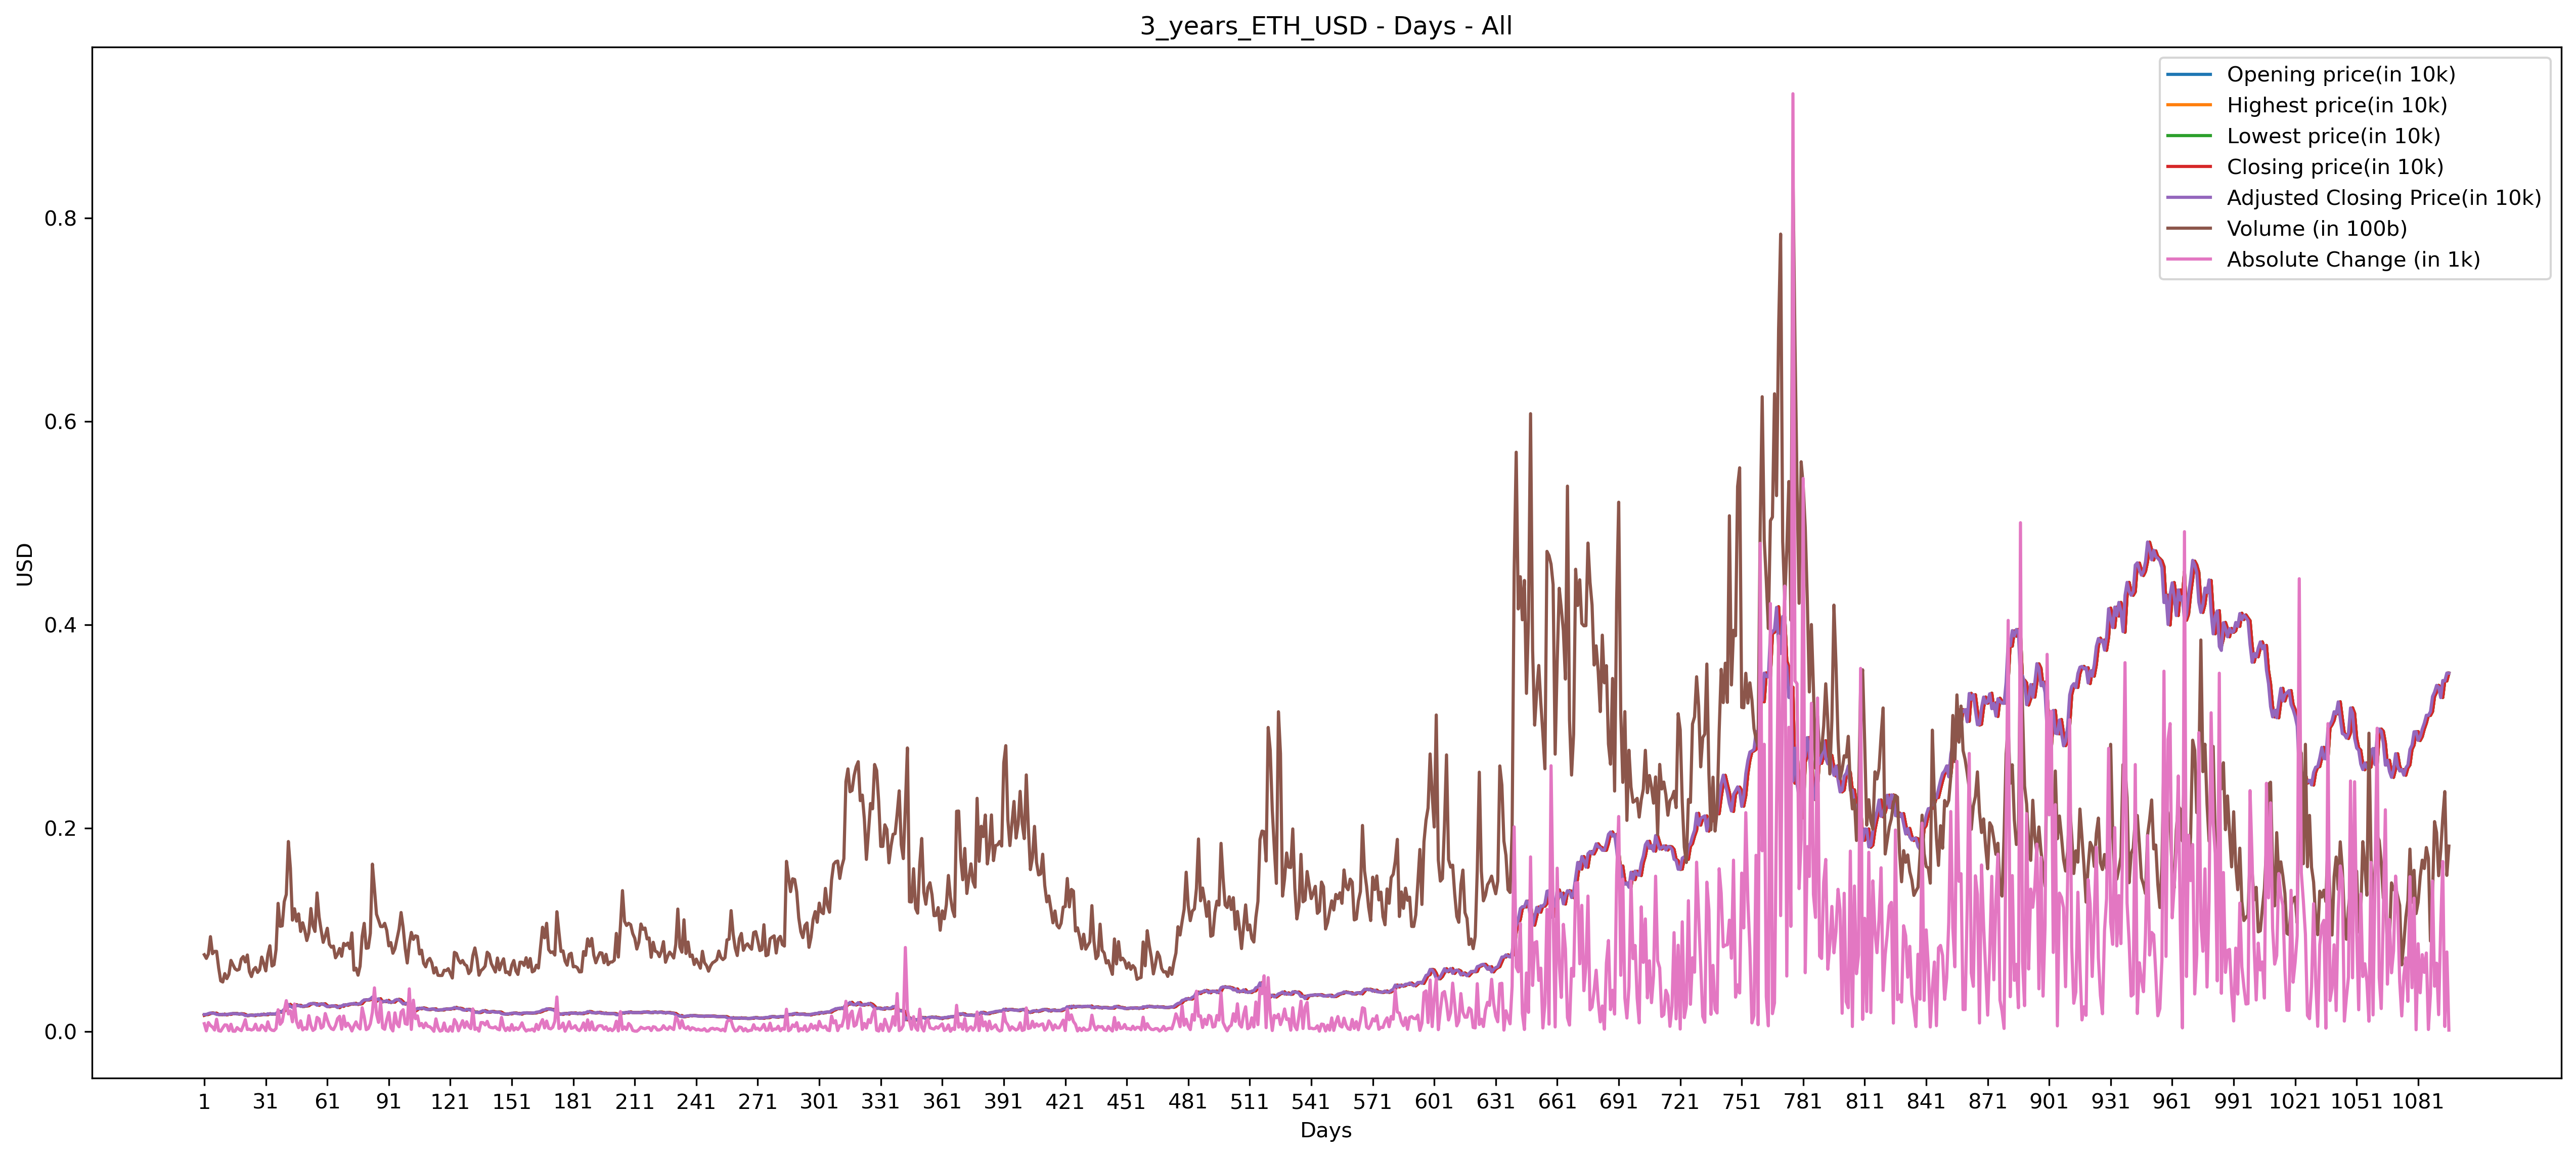

In [ ]:
# showing features relation
for key in datasets.keys():
    dataset = datasets[key]["dataset"]
    x_dim = [i+1 for i in range(dataset.shape[0])]
    Open = dataset[:, 0]/10000
    High = dataset[:, 1]/10000
    Low = dataset[:, 2]/10000
    Close = dataset[:, 3]/10000
    Adj_Close = dataset[:, 4]/10000
    if "BTC" in key:
        Volume = dataset[:, 5]/10000000000
    elif "ETH" in key:
        Volume = dataset[:, 5]/100000000000        
    Change = np.absolute(dataset[:, 6]/1000)
    plt.figure(figsize=(21,9),dpi=300)
    plt.title(f"{key} - Days - All")
    plt.xlabel("Days")
    plt.ylabel("USD")
    plt.plot(x_dim, Open, label = "Opening price(in 10k)")
    plt.plot(x_dim, Open, label = "Highest price(in 10k)")
    plt.plot(x_dim, Open, label = "Lowest price(in 10k)")
    plt.plot(x_dim, Open, label = "Closing price(in 10k)")
    plt.plot(x_dim, Adj_Close, label = "Adjusted Closing Price(in 10k)")
    if "BTC" in key:
        plt.plot(x_dim, Volume, label = "Volume (in 10b)")
    elif "ETH" in key:
        plt.plot(x_dim, Volume, label = "Volume (in 100b)")
    plt.plot(x_dim, Change, label = "Absolute Change (in 1k)")
    plt.xticks(np.arange(min(x_dim), max(x_dim)+1, 30))
    plt.legend()
    plt.savefig(f"{key}_Days_All.jpg")
    plt.show()

In 2 and 3 years BTC_USD datasets, there is a weird volume. We may look on that first.

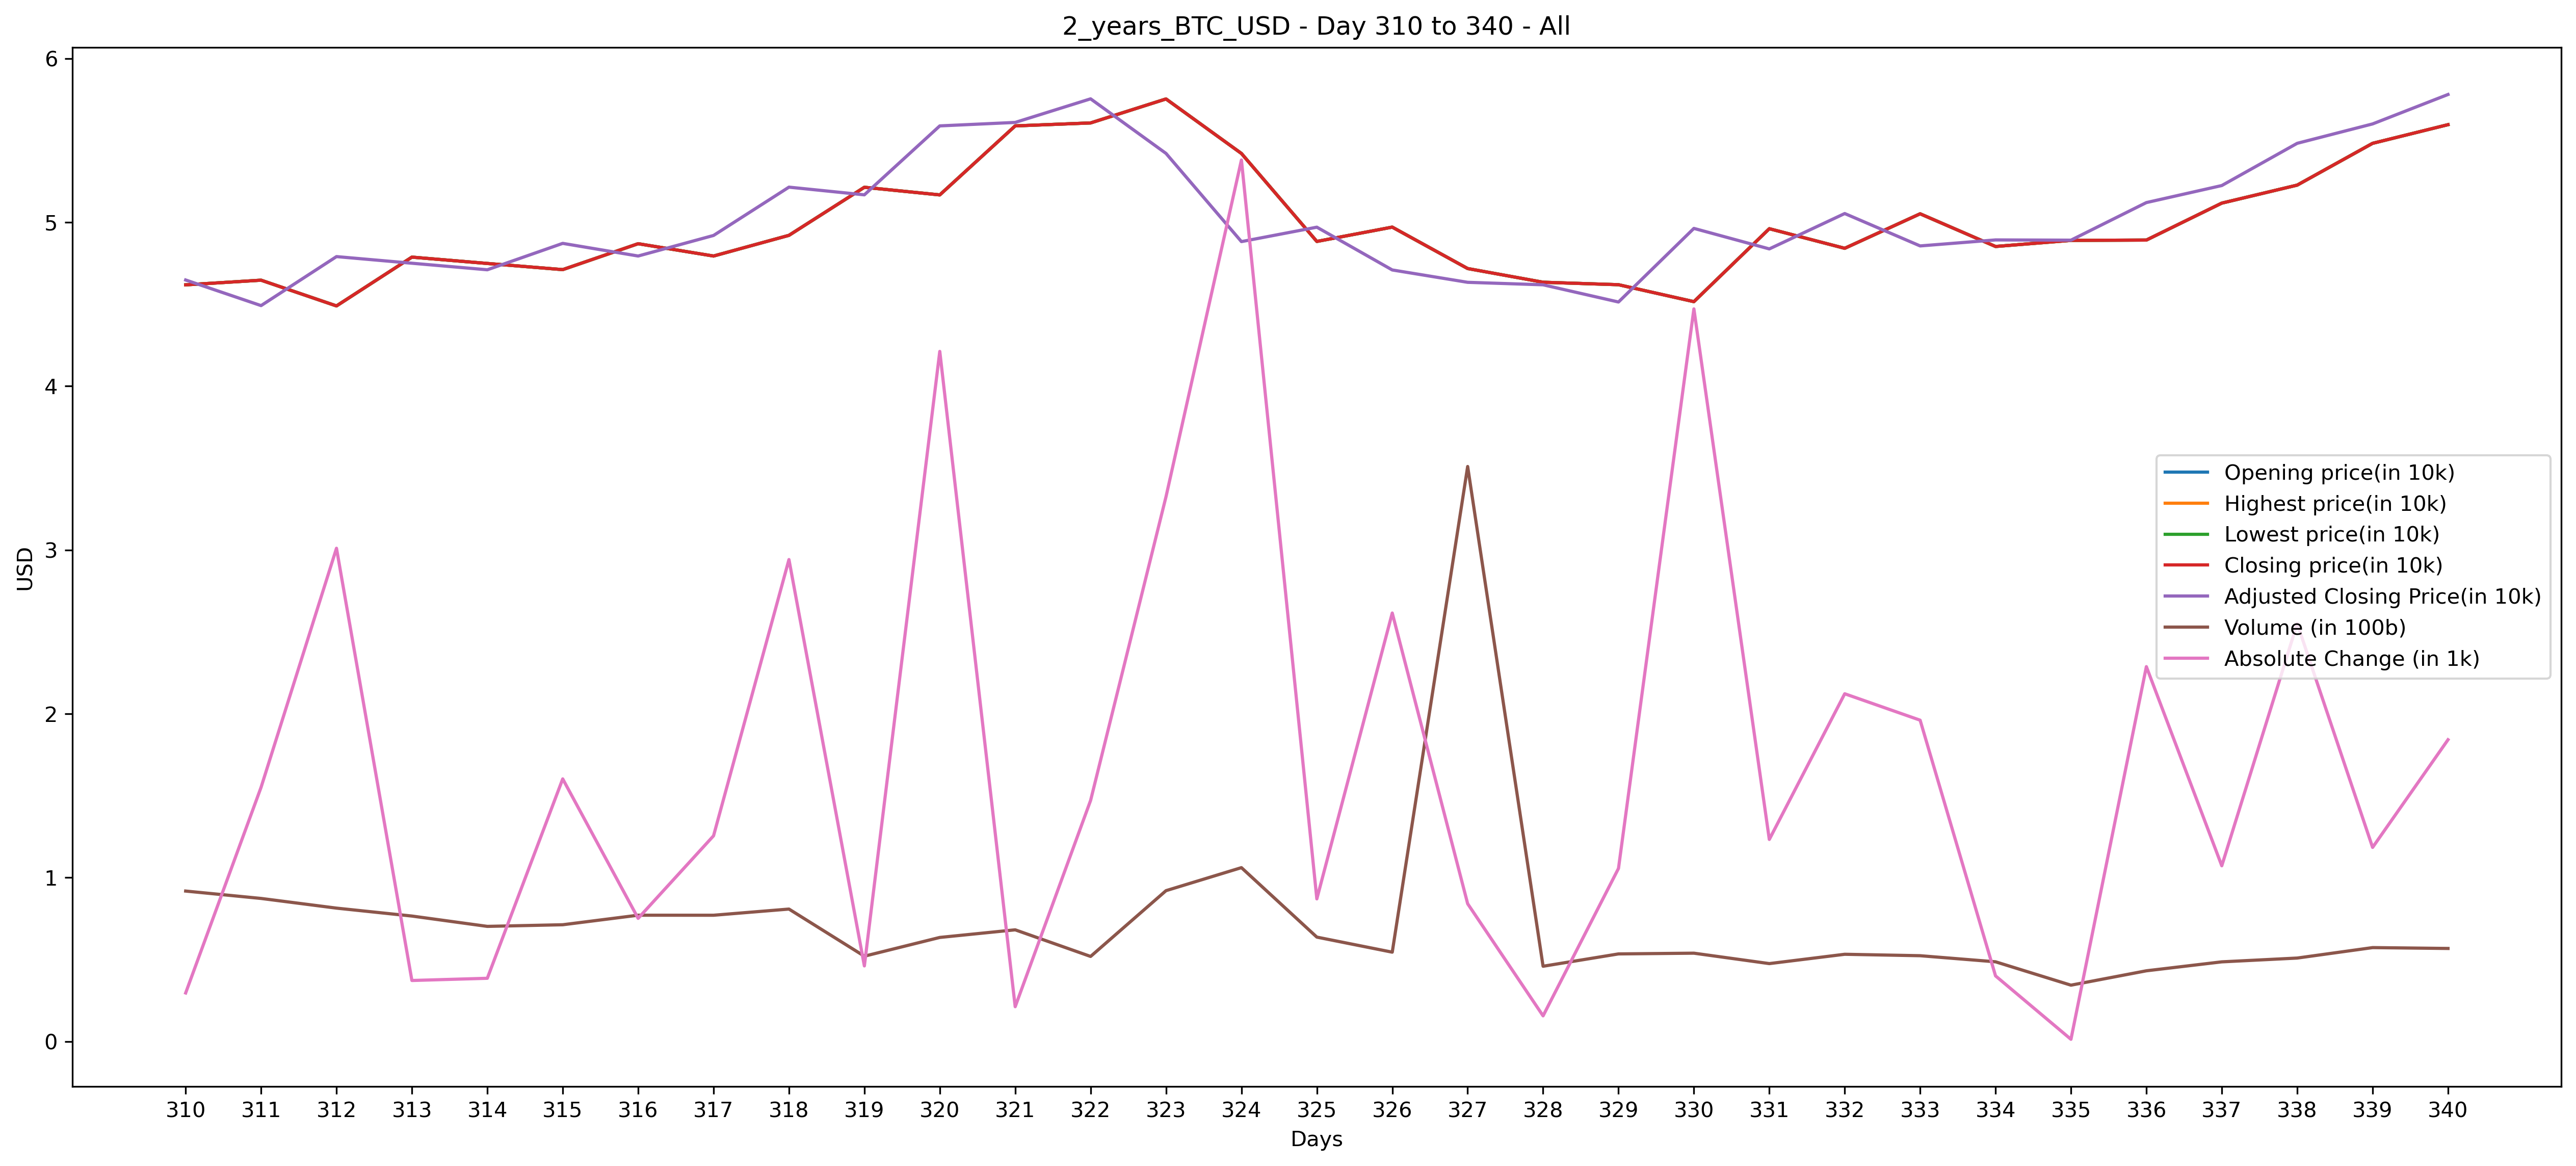

In [ ]:
dataset = datasets["2_years_BTC_USD"]["dataset"]
x_dim = [i for i in range(310, 341)]
dataset_in_310_410_days = dataset[310:341]
Open = dataset_in_310_410_days[:, 0]/10000
High = dataset_in_310_410_days[:, 1]/10000
Low = dataset_in_310_410_days[:, 2]/10000
Close = dataset_in_310_410_days[:, 3]/10000
Adj_Close = dataset_in_310_410_days[:, 4]/10000
Volume = dataset_in_310_410_days[:, 5]/100000000000    
Change = np.absolute(dataset[310:341, 6]/1000)
plt.figure(figsize=(21,9),dpi=300)
plt.title(f"2_years_BTC_USD - Day 310 to 340 - All")
plt.xlabel("Days")
plt.ylabel("USD")
plt.plot(x_dim, Open, label = "Opening price(in 10k)")
plt.plot(x_dim, Open, label = "Highest price(in 10k)")
plt.plot(x_dim, Open, label = "Lowest price(in 10k)")
plt.plot(x_dim, Open, label = "Closing price(in 10k)")
plt.plot(x_dim, Adj_Close, label = "Adjusted Closing Price(in 10k)")
plt.plot(x_dim, Volume, label = "Volume (in 100b)")
plt.plot(x_dim, Change, label = "Absolute Change (in 1k)")
plt.xticks(np.arange(min(x_dim), max(x_dim)+1, 1))
plt.legend()
plt.savefig(f"2_years_BTC_USD - Day 310 to 340 - All.jpg")
plt.show()

We can see before day 327, there is a large downs between day 323 and 325, and a little ups on day 326. These may cause the large amount of tradings on day 327. According to there is just one sample of this situation, large volume suddenly, we may delete it. And the related day in 3_years_BTC_USD dataset is 693.

By analysising the features relationship, we found that "Opening price", "Highest price", "Lowest price", "Closing price" and "Adjusted Closing Price" is very similiar. They may only affect a little bit of tommorow ups and downs. The previous day "Change", "Volume" may affect tomorrow ups and downs mainly.

In [ ]:
datasets["2_years_BTC_USD"]["dataset"] = np.delete(datasets["2_years_BTC_USD"]["dataset"], 327, axis=0)
datasets["3_years_BTC_USD"]["dataset"] = np.delete(datasets["3_years_BTC_USD"]["dataset"], 693, axis=0)

In [ ]:
# spilt dataset
for key in datasets.keys():
    dataset_detail = datasets[key]
    dataset = dataset_detail["dataset"]
    # spilt data and label
    dataset_detail["X"] = dataset[:,:-1]
    dataset_detail["y"] = dataset[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(dataset_detail["X"], dataset_detail["y"], 
                                                        test_size=0.1, random_state=0)
    dataset_detail["X_train"] = X_train
    dataset_detail["X_test"] = X_test
    dataset_detail["y_train"] = y_train
    dataset_detail["y_test"] = y_test

In [ ]:
# train and evaluate model
# by knn, nb
def gscv(dataset_detail, grid_params, model_instance, model_name):
    dataset = dataset_detail["dataset"]
    dataset_detail["models"][model_name] = {}
    model_detail = dataset_detail["models"][model_name]
    
    # start to find model with best parameter
    start_time = default_timer()
    gs = GridSearchCV(model_instance, grid_params, cv=min(cpu_number*2, dataset.shape[0]**0.5), n_jobs = max(1, cpu_number//2))
    g_res = gs.fit(dataset_detail["X_train"], dataset_detail["y_train"])
    end_time = default_timer()
    
    # record information
    model_detail["model"] = g_res
    model_detail["time_for_training"] = end_time-start_time
    model_detail["model_params"] = g_res.best_params_
    model_detail["score"] = g_res.score(dataset_detail["X_test"], dataset_detail["y_test"])
    
    # test predict whole set time
    start_time = default_timer()
    g_res.predict_proba(dataset_detail["X_test"])
    end_time = default_timer()
    model_detail["time_for_predict_test_set"] = end_time-start_time
    

def knn(dataset_detail):
    # knn parameters used to find best model
    grid_params = {'n_neighbors' : list(range(2, round(dataset_detail["dataset"].shape[0]**0.5))),
                   'metric' : ['minkowski','euclidean','manhattan']}
    gscv(dataset_detail, grid_params, KNeighborsClassifier(), "knn")


def nb(dataset_detail):
    # nb parameters used to find best model
    grid_params = {"var_smoothing":[1/10**i for i in range(9, max(16, cpu_number**3))]}
    gscv(dataset_detail, grid_params, GaussianNB(), "nb")
    
def rfc(dataset_detail):
    grid_params = {'n_estimators': list(range(91,162, 2)),
                   'max_features': [3],
                   'max_depth' : list(range(4,9)),
                   'criterion' :['gini', 'entropy']}
    gscv(dataset_detail, grid_params, RandomForestClassifier(random_state=0), "rfc")
    
    
for key in datasets.keys():
    print(f"Traning: {key}")
    dataset_detail = datasets[key]
    
    start_time = default_timer()
    knn(dataset_detail)
    knn_end_time = default_timer()
    print(f"KNN used time: {knn_end_time - start_time}")
    
    nb(dataset_detail)
    nb_end_time = default_timer()
    print(f"Navie Bayves used time: {nb_end_time - knn_end_time}")
    
    rfc(dataset_detail)
    rfc_end_time = default_timer()
    print(f"Random Forest used time: {rfc_end_time - nb_end_time}")
    
    print(f"Total used time: {rfc_end_time - start_time}")

Traning: 1_year_BTC_USD
KNN used time: 2.7918838999999984
Navie Bayves used time: 3.4851314
Random Forest used time: 328.0767152
Total used time: 334.3537305
Traning: 2_years_BTC_USD
KNN used time: 1.2110620999999924
Navie Bayves used time: 2.9947685999999862
Random Forest used time: 424.09720960000004
Total used time: 428.3030403
Traning: 3_years_BTC_USD
KNN used time: 1.7722217000000455
Navie Bayves used time: 2.780459599999972
Random Forest used time: 529.9141000000001
Total used time: 534.4667813000001
Traning: 1_year_ETH_USD
KNN used time: 0.6803804999999556
Navie Bayves used time: 3.6002972000001137
Random Forest used time: 362.0401873999999
Total used time: 366.3208651
Traning: 2_years_ETH_USD
KNN used time: 1.2369415999999092
Navie Bayves used time: 3.135762999999997
Random Forest used time: 440.0312875000002
Total used time: 444.4039921000001
Traning: 3_years_ETH_USD
KNN used time: 1.825747500000034
Navie Bayves used time: 3.3022234000000026
Random Forest used time: 477.262214

In [ ]:
# mid report
print("Information of trained model")
print("----------------------------------------------------")
print("----------------------------------------------------")
for key in datasets.keys():
    print(key)
    dataset_detail = datasets[key]
    print(f"Test set size: {dataset_detail['X_test'].shape[0]}")
    models = dataset_detail["models"]
    for model_name in models.keys():
        model = models[model_name]
        print(model_name)
        print(f"Time for training: {model['time_for_training']}")
        print(f"Time for predict test set: {model['time_for_predict_test_set']}")
        print(f"Score: {model['score']}")
    print("----------------------------------------------------")
        

Information of trained model
----------------------------------------------------
----------------------------------------------------
1_year_BTC_USD
Test set size: 37
knn
Time for training: 2.7875451000000027
Time for predict test set: 0.0013313000000003683
Score: 0.4864864864864865
nb
Time for training: 3.4834653000000024
Time for predict test set: 0.000192899999998275
Score: 0.5945945945945946
rfc
Time for training: 328.05247310000004
Time for predict test set: 0.010906099999999697
Score: 0.5945945945945946
----------------------------------------------------
2_years_BTC_USD
Test set size: 73
knn
Time for training: 1.2071353000000045
Time for predict test set: 0.0007988000000409556
Score: 0.3972602739726027
nb
Time for training: 2.993378699999994
Time for predict test set: 0.0001989000000435226
Score: 0.5616438356164384
rfc
Time for training: 424.08230960000003
Time for predict test set: 0.006974300000024414
Score: 0.5068493150684932
-------------------------------------------------

In [ ]:
# Evaluation
# By existing tools
for key in datasets.keys():
    print(f"Dataset: {key}")
    dataset_detail = datasets[key]
    X_test = dataset_detail["X_test"]
    y_test = dataset_detail["y_test"]
    models_details = dataset_detail["models"]
    for model_name in models_details.keys():
        print(f"Model: {model_name}")
        start_time = default_timer()
        model = models_details[model_name]["model"]
        y_test_predict_pred = model.predict(X_test)
        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_test_predict_pred))
        print("Classification report:")
        print(classification_report(y_test, y_test_predict_pred))
        scores = accuracy_score(y_test, y_test_predict_pred)
        print('Model accuracy: ',np.mean(scores))
        end_time = default_timer()
        print("Evaluation time:", end_time-start_time)
        print("----------------------------------------------------")
    print("----------------------------------------------------")



Dataset: 1_year_BTC_USD
Model: knn
Confusion matrix:
[[ 8 13]
 [ 6 10]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.57      0.38      0.46        21
         1.0       0.43      0.62      0.51        16

    accuracy                           0.49        37
   macro avg       0.50      0.50      0.48        37
weighted avg       0.51      0.49      0.48        37

Model accuracy:  0.4864864864864865
Evaluation time: 0.007635000000391301
----------------------------------------------------
Model: nb
Confusion matrix:
[[10 11]
 [ 4 12]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.71      0.48      0.57        21
         1.0       0.52      0.75      0.62        16

    accuracy                           0.59        37
   macro avg       0.62      0.61      0.59        37
weighted avg       0.63      0.59      0.59        37

Model accuracy:  0.5945945945945946
Evaluation time: 0

Confusion matrix:
[[19 33]
 [25 33]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.43      0.37      0.40        52
         1.0       0.50      0.57      0.53        58

    accuracy                           0.47       110
   macro avg       0.47      0.47      0.46       110
weighted avg       0.47      0.47      0.47       110

Model accuracy:  0.4727272727272727
Evaluation time: 0.008705400000053487
----------------------------------------------------
Model: nb
Confusion matrix:
[[ 8 44]
 [ 5 53]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.62      0.15      0.25        52
         1.0       0.55      0.91      0.68        58

    accuracy                           0.55       110
   macro avg       0.58      0.53      0.47       110
weighted avg       0.58      0.55      0.48       110

Model accuracy:  0.5545454545454546
Evaluation time: 0.005059600000095088
---------------

Our aim is to provide the probability of ups or downs
In previous evaluations, they are based on the predict function
So the following will implement some evaluations method based on the predict_proba function

In [ ]:
# Evaluate and find best usage by self method
def calculate_confusion_matrix(true_cases, pred_cases, confidence):
    # only 2 labels for us (0,1)
    matrix = np.zeros((2,2))
    count = 0
    for case_number, probas in enumerate(pred_cases):
        # get index of larger probaility
        max_proba_index = np.argmax(probas)
        # get related true case
        true_case = true_cases[case_number]
        # only when ups probabilty is more then confidence, or any down probabilty is more then 50
        if max_proba_index==0 or probas[1] >= confidence:
            matrix[int(true_case), max_proba_index] += probas[max_proba_index]
            count+=1
    return matrix, count

def calculate_accuracy(matrix):
    true_value = 0
    for i in range(len(matrix)):
        true_value+=matrix[i][i]
    total = np.sum(matrix)
    if total == 0:
        raise
    return true_value/total

def calculate_precision(matrix, label):
    TP = matrix[label, label]
    FPTP = matrix[:,label]
    sum_FPTP = np.sum(FPTP)
    if sum_FPTP == 0:
        raise
    return TP/sum_FPTP

def calculate_recall(matrix, label):
    TP = matrix[label, label]
    FNTP = matrix[label]
    sum_FNTP = np.sum(FNTP)
    if sum_FNTP == 0:
        raise
    return TP/sum_FNTP

def print_precision_recall(labels):
    print("Classification report:")
    for key in labels.keys():
        label = labels[key]
        print(f"Label: {key}")
        print(f"Precision: {label['precision']}")
        print(f"Recall: {label['recall']}")
        print()
    
def scoring(dataset_detail):
    X_test = dataset_detail["X_test"]
    y_test = dataset_detail["y_test"]
    models_details = dataset_detail["models"]
    
    for model_name in models_details.keys():
        print(f"Model: {model_name}")
        model_detail = models_details[model_name]
        model = model_detail["model"]
        y_test_pred = model.predict_proba(X_test)
        
        # find best confidence value
        best_confidence_combination = {}
        for confidence in np.arange(0.5, 1, 1e-4):
            try:
                # get confusion matrix
                test_set_confusion_matrix, count = calculate_confusion_matrix(y_test, y_test_pred, confidence)
                accepted_rate = count/X_test.shape[0]
                
                # get precision & recall
                labels = {0:{}, 1:{}}
                for key in labels.keys():
                    label = labels[key]
                    label["precision"] = calculate_precision(test_set_confusion_matrix, key)
                    label["recall"] = calculate_recall(test_set_confusion_matrix, key)
                importance = (labels[0]['recall'] + labels[1]['precision'])/2
                # get accuracy
                test_set_accuracy = calculate_accuracy(test_set_confusion_matrix)

                if (
                    not best_confidence_combination or
                    accepted_rate >= min_accepted_rate and
                    best_confidence_combination["test_set_accuracy"] < test_set_accuracy
                   ):
                    best_confidence_combination["test_set_confusion_matrix"] = test_set_confusion_matrix
                    best_confidence_combination["labels"] = labels
                    best_confidence_combination["importance"] = importance
                    best_confidence_combination["test_set_accuracy"] = test_set_accuracy
                    best_confidence_combination["confidence"] = confidence
                    best_confidence_combination["accepted_case_rate"] = accepted_rate
            except:
                break
                
                
        model_detail["test_set_confusion_matrix"] = best_confidence_combination["test_set_confusion_matrix"]
        model_detail["labels"] = best_confidence_combination["labels"]
        model_detail["importance"] = best_confidence_combination["importance"]
        model_detail["test_set_accuracy"] = best_confidence_combination["test_set_accuracy"]
        model_detail["confidence"] = best_confidence_combination["confidence"]
        model_detail["accepted_case_rate"] = best_confidence_combination["accepted_case_rate"]
        
        print(f"Confidence when probability larger than: {model_detail['confidence']}")
        print(f"Accepted case rate: {model_detail['accepted_case_rate']}")
        print("Confusion matrix:")
        print(model_detail["test_set_confusion_matrix"])
        print_precision_recall(model_detail["labels"])
        print(f"Importance: {model_detail['importance']}")            
        print(f"Model accuracy: {model_detail['test_set_accuracy']}")
        print("----------------------------------------------------")
        print("----------------------------------------------------")

for key in datasets.keys():
    dataset_detail = datasets[key]
    print(f"Dataset: {key}")
    scoring(dataset_detail)
    print("----------------------------------------------------\n")

Dataset: 1_year_BTC_USD
Model: knn
Confidence when probability larger than: 0.5
Accepted case rate: 1.0
Confusion matrix:
[[5.  8. ]
 [4.  5.8]]
Classification report:
Label: 0
Precision: 0.5555555555555555
Recall: 0.3846153846153845

Label: 1
Precision: 0.42028985507246375
Recall: 0.5918367346938775

Importance: 0.4024526198439241
Model accuracy: 0.4736842105263157
----------------------------------------------------
----------------------------------------------------
Model: nb
Confidence when probability larger than: 0.7923999999999678
Accepted case rate: 0.5135135135135135
Confusion matrix:
[[7.20238268 0.82966898]
 [3.56095051 3.26719317]]
Classification report:
Label: 0
Precision: 0.6691591308240219
Recall: 0.8967052236356945

Label: 1
Precision: 0.7974867230657744
Recall: 0.4784892244230141

Importance: 0.8470959733507344
Model accuracy: 0.7045382388315695
----------------------------------------------------
----------------------------------------------------
Model: rfc
Confide

Confidence when probability larger than: 0.5526999999999942
Accepted case rate: 0.6636363636363637
Confusion matrix:
[[ 4.42709164 13.61625356]
 [ 2.79071663 21.54440907]]
Classification report:
Label: 0
Precision: 0.6133567805043322
Recall: 0.24535869560965262

Label: 1
Precision: 0.6127418386725485
Recall: 0.885321462369832

Importance: 0.42905026714110056
Model accuracy: 0.6128465742174073
----------------------------------------------------
----------------------------------------------------
Model: rfc
Confidence when probability larger than: 0.6842999999999797
Accepted case rate: 0.5545454545454546
Confusion matrix:
[[11.10458     5.1890222 ]
 [13.83625459  8.10617735]]
Classification report:
Label: 0
Precision: 0.4452369050208564
Recall: 0.6815300794981474

Label: 1
Precision: 0.6097070843399821
Recall: 0.36942930368620097

Importance: 0.6456185819190647
Model accuracy: 0.5024254681991818
----------------------------------------------------
--------------------------------------

In [ ]:
# find best combination of dataset and model
def get_best_dataset_model():
    best_dataset_model = {}
    for key in datasets.keys():
        dataset_detail = datasets[key]
        models = dataset_detail["models"]
        for model_name in models.keys():
            model_detail = models[model_name]
            accuracy = model_detail["test_set_accuracy"]
            confidence = model_detail["confidence"]
            if (not best_dataset_model or 
                best_dataset_model["test_set_accuracy"] < accuracy):
                best_dataset_model["importance"] = model_detail["importance"]
                best_dataset_model["dataset_name"] = key
                best_dataset_model["dataset_detail"] = dataset_detail
                best_dataset_model["model_name"] = model_name
                best_dataset_model["model"] = model_detail["model"]
                best_dataset_model["labels"] = model_detail["labels"]
                best_dataset_model["confidence"] = model_detail["confidence"]
                best_dataset_model["accepted_case_rate"] = model_detail["accepted_case_rate"]
                best_dataset_model["test_set_accuracy"] = model_detail["test_set_accuracy"]
        best_dataset_model["dataset_detail"] = dataset_detail
    return best_dataset_model

best_dataset_model = get_best_dataset_model()

print("Best combination of dataset and model")
print(f"Days to predict: {day_to_predict}")
print(f"Dataset: {best_dataset_model['dataset_name']}")
print(f"Model: {best_dataset_model['model_name']}")
print(f"Confidence: {best_dataset_model['confidence']}")
print(f"Accepted case rate: {best_dataset_model['accepted_case_rate']}")
print(f"Importance: {best_dataset_model['importance']}")
print(f"Accuracy: {best_dataset_model['test_set_accuracy']}")
print("----------------------------------------------------")
print_precision_recall(best_dataset_model["labels"])

Best combination of dataset and model
Days to predict: 1
Dataset: 1_year_BTC_USD
Model: rfc
Confidence: 0.6582999999999826
Accepted case rate: 0.5675675675675675
Importance: 1.0
Accuracy: 0.7148831710792422
----------------------------------------------------
Classification report:
Label: 0
Precision: 0.6569289107902295
Recall: 1.0

Label: 1
Precision: 1.0
Recall: 0.3720511562646114



# Conclusion
1. As the number of labels are not balance, the model accuracy may not be a great measure
2. Precision of ups(label 1) and recall of downs(label 0) mean the confident of the model telling sell and not to buy when going to downs.
3. These two values may be more important soo selecting dataset and model may rely on them. The importance value is the avgerage of them.

For Example, the importance of dataset, "1_year_BTC_USD", which using model, "rtc", is the highest one. It may be the best dataset and model.

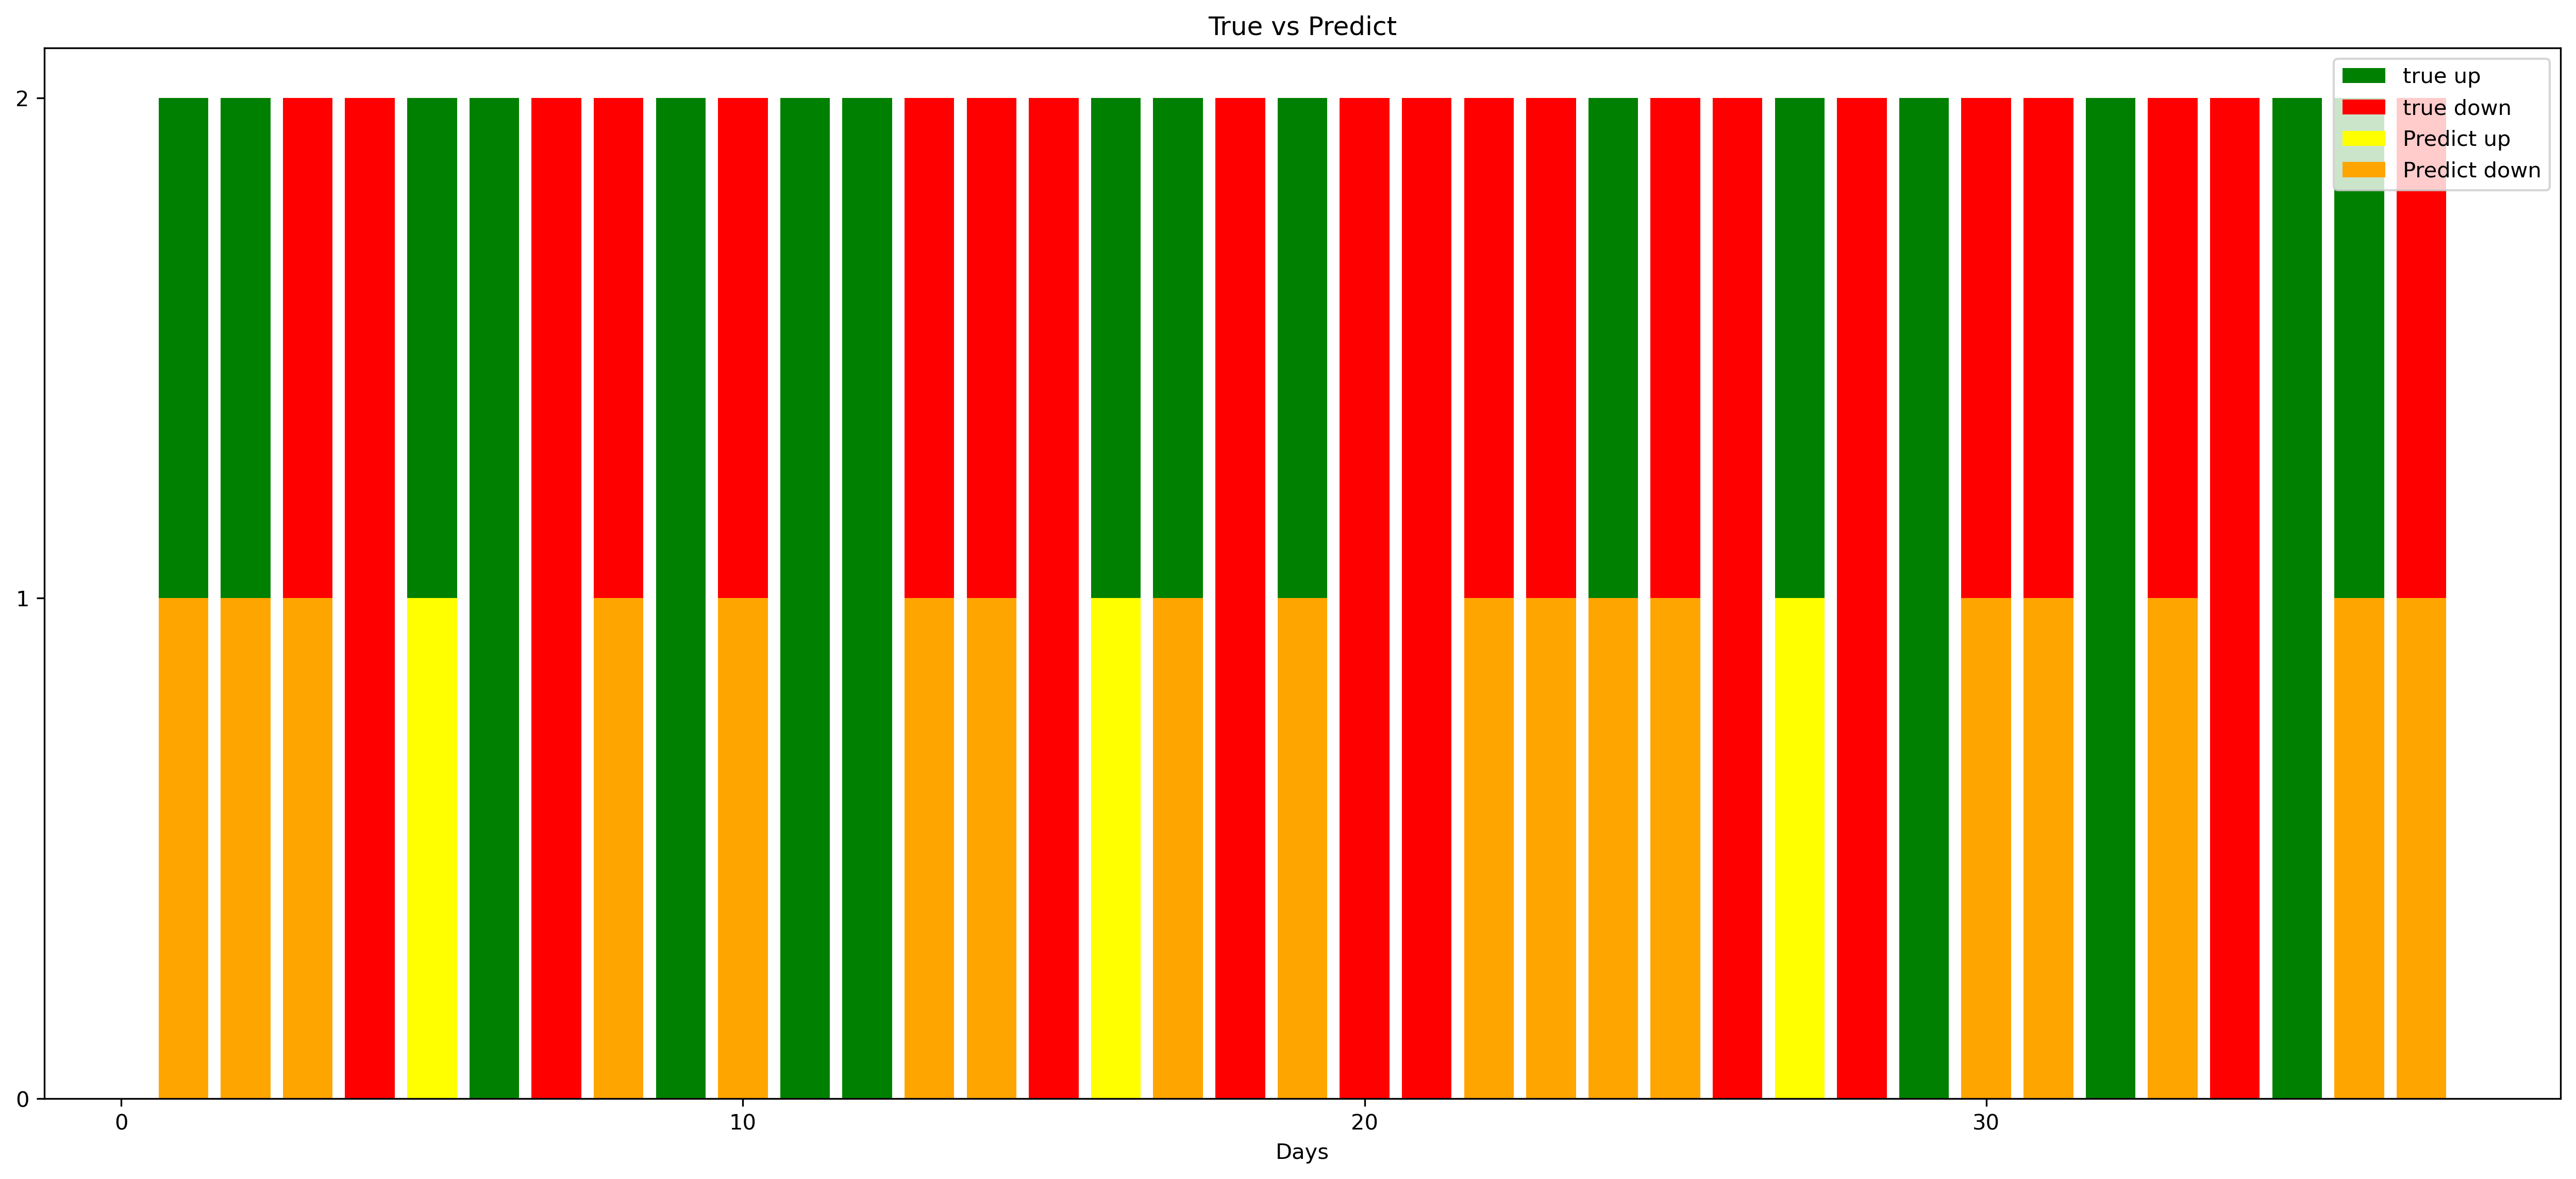

Number of true ups: 3
Predict ups accepted: 3
Predict Ups accepted same: 3
Predict Ups accepted different: 0

Number of true downs: 18
Number of downs predicted: 18
True down same: 12
True down different: 6

Correct rate: 0.71
Total used time: 2615.1991247


In [ ]:
# Visualization predict result and true result
def visualization():
    dataset = datasets["1_year_BTC_USD"]
    X = dataset["X_test"]
    y = dataset["y_test"]
    number_of_data = X.shape[0]
    predict_results = best_dataset_model['model'].predict_proba(X)
    plt.figure(figsize=(21,9),dpi=300)
    plt.title(f"True vs Predict")
    plt.xlabel("Days")
    
    ups = []
    downs = []
    for i, true_case in enumerate(y):
        if true_case:
            ups.append(i+1)
        else:
            downs.append(i+1)
    number_of_true_ups = len(ups)
    number_of_true_downs = len(downs)
    
    
    plt.bar(ups, [2 for _ in range(number_of_true_ups)], label="true up", color="green")
    plt.bar(downs, [2 for _ in range(number_of_true_downs)], label="true down", color="red")
    
    ups = []
    downs = []
    for i, probas in enumerate(predict_results):
        max_proba_index = np.argmax(probas)
        if max_proba_index == 0:
            downs.append(i+1)
        elif probas[1] >= best_dataset_model["confidence"]:
            ups.append(i+1)
    ups = np.array(ups)
    downs = np.array(downs)
    plt.bar(ups, [1 for _ in range(len(ups))], label="Predict up", color="yellow")
    plt.bar(downs, [1 for _ in range(len(downs))], label="Predict down", color="orange")
    plt.yticks(np.arange(0, 3, 1))
    plt.xticks(np.arange(0, number_of_data+1, 10))
        
    plt.legend()
    plt.savefig("True vs Predict")
    plt.show()
    
    up_accepted = len(ups)
    number_of_downs_predicted = len(downs)
    up_accepted_same = 0
    true_down_same = 0
    true_up_different = 0
    
    for up in ups:
        if y[up-1] == 1:
            up_accepted_same += 1
    
    for down in downs:
        if y[down-1] == 0:
            true_down_same += 1
        else:
            true_up_different +=1
            
            
    up_accepted_difference = up_accepted - up_accepted_same
    true_down_different = number_of_downs_predicted - true_down_same
    number_of_true_ups = len(ups)
    number_of_true_downs = len(downs)
    
    print("Number of true ups:", number_of_true_ups)
    print("Predict ups accepted:", up_accepted)
    print("Predict Ups accepted same:", up_accepted_same)
    print("Predict Ups accepted different:", up_accepted_difference)
    print()    
    print("Number of true downs:", number_of_true_downs)
    print("Number of downs predicted:", number_of_downs_predicted)
    print("True down same:", true_down_same)
    print("True down different:", true_down_different)
    total_correct = (true_down_same+up_accepted_same)/(number_of_true_downs+number_of_true_ups)
    print()
    print("Correct rate: %.2f" %total_correct)
    
    
            
    
visualization()
program_end_time = default_timer()
print("Total used time:", program_end_time-program_start_time)

We can see that most accepted prediction ups results are same in test set, which is 100% correct. Which mean no true downs cases consider as ups.